**Synchronize to Google Drive**

This feature makes the google colab to connect to the google drive with mounting GDrive and defining the path.

In [1]:
# Synchronize to google drive, define the root path
import os

google_colab  = True
if google_colab == True:
  #This statement used to pointing the google drive storage 
  from google.colab import drive
  drive.mount('/content/gdrive')
  root_path = 'gdrive/My Drive/Colab Notebooks/'

  #This statement is purposed to import library from the Drive
  os.chdir('gdrive/My Drive/Colab Notebooks/')
  

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
import tensorflow as tf
tf.enable_eager_execution()
import numpy as np
np.random.seed(0)
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional, GRU, Activation, Flatten
from tensorflow.keras.models import Model
#from keras.models import Model
#from keras.layers import Dense, Input, Dropout, LSTM, Activation, Flatten, GRU, Concatenate
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.callbacks import EarlyStopping
np.random.seed(1)

**Loading the dataset**

Currently, The experiment is using the dataset from CNN/Daily News. It designed to support Extractive Summarization method in which extract all of documents through pre-processing and store all of sentences to cnn-sentences.pkl and each of sentence has labeled based on whether its sentence is similar or exist on the summaries/highlight (labeled 1) or no (labeled 0)

In [3]:
import nltk
import collections
import pickle #data preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
nltk.download('punkt')
NUM_WORDS=25000
counter = collections.Counter()
print('Dataset loading ...')
#import postprocessing as pr #helper
#Step 1 - Load data
#Step 1 - Load data
with open('datasets/dataset-duc2001.pkl', 'rb') as fp:
    data_2001 = pickle.load(fp)

with open('datasets/dataset-duc2002.pkl', 'rb') as fp:
    data_2002 = pickle.load(fp)

clusterSentences_2001, clusterDocuments_2001, clusterSummaries_2001, listY_2001 = data_2001
clusterSentences_2002, clusterDocuments_2002, clusterSummaries_2002, listY_2002 = data_2002

clusterSentences = clusterSentences_2001 + clusterSentences_2002
listY = listY_2001 + listY_2002

# Extract to become one bucket of sentences
sentences = []
for clusterSentence in clusterSentences:
  for sentence in clusterSentence:
    sentences.append(sentence)

tokenizer = Tokenizer(num_words=NUM_WORDS,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'',lower=True)
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
index_word = tokenizer.index_word
index_docs = tokenizer.index_docs
vocabularySize = len(word_index) + 1

#nWord = [len(sentence.split()) for sentence in sentences]
#nWord = sorted(nWord,  reverse=True)
#words = [sentence.split() for sentence in sentences]
#nWord = [len(sentence.split()) for sentence in sentences]
#maxlen = max(nWord)
sentenceLength = 200

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Dataset loading ...


**Load Pre-trained Word2Vec**

In [5]:
from gensim.models import KeyedVectors
WORD2VEC_MODEL = "word-embeddings/word2vec/GoogleNews-vectors-negative300.bin.gz"
word2vec = KeyedVectors.load_word2vec_format(WORD2VEC_MODEL, binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


**Embedding Layer**

This function is used to embed pre-trained word2vec as defined before

In [0]:
# GRADED FUNCTION: pretrained_embedding_layer
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map["cucumber"].shape[0]      # define dimensionality of your GloVe word vectors (= 50)
    
    ### START CODE HERE ###
    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        try:
          emb_matrix[index, :] = word_to_vec_map[word]
        except:
          emb_matrix[index, :] = 0

    # Define Keras embedding layer with the correct output/input sizes, make it non-trainable. Use Embedding(...). Make sure to set trainable=False. 
    embedding_layer = Embedding(vocab_len, emb_dim, trainable=False)
    ### END CODE HERE ###

    # Build the embedding layer, it is required before setting the weights of the embedding layer. Do not modify the "None".
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [0]:
embedding_layer = pretrained_embedding_layer(word2vec, word_index)

**Model 3 (GRU with Attention)**

In [0]:
def model_3(input_shape, word_to_vec_map, word_to_index):
    """
    Function creating the Emojify-v2 model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    emb_dim=300
    encoder_inputs = Input(input_shape, dtype='int32')
    
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    embeddings = embedding_layer(encoder_inputs)  
    
    # Sentence Embedding
    GRUsents = GRU(300, return_sequences=True, return_state=True, dropout=0.2, recurrent_dropout=0.2) 
    sentence_embedding, state_h =  GRUsents(embeddings)
    
    # Document Embedding
    GRUdocs = GRU(300, return_sequences=False, return_state=False, dropout=0.2, recurrent_dropout=0.2)
    output = GRUdocs(sentence_embedding)
    
    X = Dense(2)(output)
    X = Activation('softmax')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=encoder_inputs, outputs=X)
    ### END CODE HERE ###
    
    return model

**Build the model and summary**

In [20]:
model = model_3((sentenceLength,), word2vec, word_index)
model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 200, 300)          9111900   
_________________________________________________________________
gru_4 (GRU)                  [(None, 200, 300), (None, 540900    
_________________________________________________________________
gru_5 (GRU)                  (None, 300)               540900    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 602       
_________________________________________________________________
activation_1 (Activation)    (None, 2)                 0         
Total params: 10,194,302
Trainable params: 1,082,402
Non-trainable params: 9,111,900
________________________________________

**Compile the Model and Train the Model**

In [0]:
from tensorflow.keras.optimizers import Adam
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001, clipnorm=1.0), metrics=['accuracy'])

In [22]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y
    
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
xs, ys = [], []
print(len(sentences))
for sentence in sentences:
  words = [x.lower() for x in sentence.split()]
  wids = [word_index[word] for word in words]
  xs.append(wids)

ys = []
for clusterY in listY:
  for sentenceY in clusterY:
    ys.append(sentenceY)

X = pad_sequences(xs, maxlen=sentenceLength)
Y = np.array(ys)
print(Y[0])
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.02, random_state=1)
Y_train_oh = convert_to_one_hot(Ytrain, C = 2)
Y_test_oh = convert_to_one_hot(Ytest, C = 2)

print(Y_train_oh[0])
print(Y_test_oh[0])
#Y_train_oh = Y_train_oh.reshape(Y_train_oh.shape[0], Y_train_oh.shape[1], 1)
#Y_test_oh = Y_test_oh.reshape(Y_test_oh.shape[0], Y_test_oh.shape[1], 1)
#print(Y_train_oh[0])
#print(Y_test_oh[0])

28787
0
[1. 0.]
[1. 0.]


In [23]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = model.fit(Xtrain,Y_train_oh, epochs = 20, batch_size = 512, validation_data=(Xtest, Y_test_oh), callbacks=[es])
score = model.evaluate(Xtest, Y_test_oh, verbose=1)
print("Test score: {:.3f}, accuracy: {:.3f}".format(score[0], score[1]))

with open('rnn/models/model2-trainHistoryDict', 'wb') as file_pi:
  pickle.dump(history.history, file_pi)
  print("Saved training history to disk")

Train on 28211 samples, validate on 576 samples
Epoch 1/20
28211/28211 [==============================] - 620s 22ms/sample - loss: 0.2344 - acc: 0.9402 - val_loss: 0.2282 - val_acc: 0.9375
Epoch 2/20
28211/28211 [==============================] - 613s 22ms/sample - loss: 0.2022 - acc: 0.9434 - val_loss: 0.2083 - val_acc: 0.9375
Epoch 3/20
28211/28211 [==============================] - 612s 22ms/sample - loss: 0.1719 - acc: 0.9436 - val_loss: 0.1928 - val_acc: 0.9375
Epoch 4/20
28211/28211 [==============================] - 612s 22ms/sample - loss: 0.1670 - acc: 0.9436 - val_loss: 0.1816 - val_acc: 0.9375
Epoch 5/20
28211/28211 [==============================] - 612s 22ms/sample - loss: 0.1606 - acc: 0.9444 - val_loss: 0.1812 - val_acc: 0.9375
Epoch 6/20
28211/28211 [==============================] - 615s 22ms/sample - loss: 0.1560 - acc: 0.9449 - val_loss: 0.1756 - val_acc: 0.9392
Epoch 7/20
28211/28211 [==============================] - 613s 22ms/sample - loss: 0.1520 - acc: 0.9448 - 

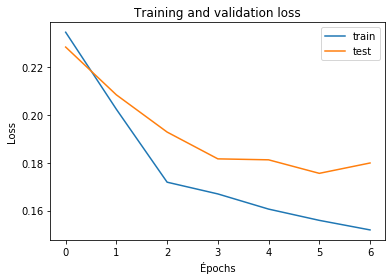

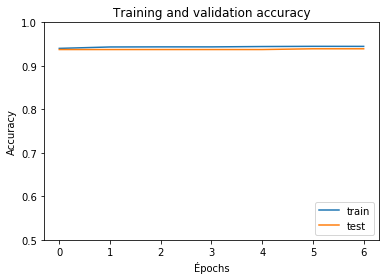

In [24]:
from matplotlib import pyplot
fig = pyplot.figure()
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.title('Training and validation loss')
pyplot.xlabel('Épochs')
pyplot.ylabel('Loss')
pyplot.legend() 
pyplot.show()
#fname='training-and-validation-loss-model2.jpg'
#fig.savefig(fname)

fig2 = pyplot.figure()
pyplot.plot(history.history['acc'], label='train') 
pyplot.plot(history.history['val_acc'], label='test') 
pyplot.title('Training and validation accuracy')
pyplot.xlabel('Épochs')
pyplot.ylabel('Accuracy')
pyplot.legend(loc='lower right')
pyplot.ylim((0.5, 1))
pyplot.show()
#fname='training-and-validation-accuracy-model2.jpg'
#fig2.savefig(fname)

**Model Prediction**

In [51]:
test_docs = clusterSentences[15]
xs_test=[]
#print(len(test_docs))
for sentence in test_docs:
  words = [x.lower() for x in nltk.word_tokenize(sentence)]
  wids = [word_index[word] for word in words]
  xs_test.append(wids)
X_Test = pad_sequences(xs_test, maxlen=sentenceLength)
Y_Test = np.array(listY[0])
pred = model.predict(X_Test)
sentence_test = []
salience_score_list = {}
score_list = []
for i in range(len(X_Test)):
    num = np.argmax(pred[i])
    pred_num = pred[i]
    sentence_list = []
    for idx in X_Test[i]:
      if idx != 0:
        sentence_list.append(index_word[idx])
    sentence_list = ' '.join(sentence_list)
    salience_score_list[sentence_list] = pred_num[1]
    sentence_test.append(sentence_list)

ordering = sorted(salience_score_list, key=lambda k: salience_score_list[k],  reverse=True)
summary_list = []
sentence_length = 0
for sent in ordering:
  length = len(sent.split())
  if (length > 5 and length < 55):
    if sentence_length <= 88:
      #print(len(sent.split()))
      summary_list.append(sent)
      sentence_length += length
summary = ' '.join(summary_list)
print('Predicted Summary:')
print(summary)
print()
print('Length of summary',len(summary.split()))
print()
print('The summary sentences salience score:')
for sent in summary_list:
  print(salience_score_list[sent])

Predicted Summary:
however director lu ping and hong kong governor chris patten granted separate exclusive interviews to the information department of hong kong television broadcasts limited and expressed their opinions on some issues in dispute between china and britain the hong kong and macao affairs office of the chinese government in a dispatch released through the xinhua news agency in beijing said that all contracts leases and agreements signed and ratified by the hong kong government would be invalid after june 30 1997 unless they were first approved by china as for making the hong kong system living automatic and autonomous the relations between china and the special entity of hong kong how the two should be integrated and to what extent as well as the costs and benefits of such integration none of that has been considered at length

Length of summary 138

The summary sentences salience score:
0.7110149
0.6685624
0.66527027


In [39]:

!pip install rouge
from rouge import Rouge

In [48]:
clusterSummaries = clusterSummaries_2001 + clusterSummaries_2002
print('Original Summary')
print(clusterSummaries[15])

print('Length of original summary', len(clusterSummaries[15].split()))

Original Summary
Hong Kong Governor Chris Patten and Lu Ping director of Chinas Office of Hong Kong and Macau Affairs generally find little agreement Lu Ping accuses Patten of duplicity and Patten sees Hong Kong operating best in its own interests free from Chinese consultation The Chinese doubt that the British want to return the colony to China The colony will become a special administrative region of China in 1997 still operating as a capitalist system under Chinas one country two systems plan The Chinese want negotiations with the British in the Preliminary Working Group but Patten wants the Joint Liaison Group 
Length of original summary 100


In [49]:

rouge = Rouge()
scores = rouge.get_scores(summary, clusterSummaries[15])
print('Rouge Scores')
print(scores)
print('Average Rouge Score')
average = (scores[0]['rouge-1']['f'] + scores[0]['rouge-2']['f'])/2 
print(average)

Rouge Scores
[{'rouge-1': {'f': 0.16149067837043338, 'p': 0.13829787234042554, 'r': 0.19402985074626866}, 'rouge-2': {'f': 0.0, 'p': 0.0, 'r': 0.0}, 'rouge-l': {'f': 0.10600196049418763, 'p': 0.09574468085106383, 'r': 0.13432835820895522}}]
Average Rouge Score
0.08074533918521669
